In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os
import pickle
from matplotlib.backends.backend_pdf import PdfPages
import math

In [2]:
#first let's change all of the .fcs extensions to .txt

directory = os.getcwd()

for filename in os.listdir(directory):
    if filename.lower().endswith(".fcs"):
        base = os.path.splitext(filename)[0]
        old_path = os.path.join(directory, filename)
        new_path = os.path.join(directory, base + ".txt")
        os.rename(old_path, new_path)
        print(f'Renamed: {filename} → {base}.txt')

In [3]:
#finding the noise measurement and correlation curve 

def extract_blocks(filepath):
    with open(filepath, 'r', encoding='latin1') as file:
        lines = [line.strip() for line in file]

    noise_blocks = []
    corr_blocks = []

    i = 0
    while i < len(lines):
        # --- Detect CountRateArray block ---
        if lines[i].startswith("CountRateArray ="):
            i += 1  # Move to first data line
            block = []
            while i < len(lines) and not lines[i].startswith("CorrelationArraySize"):
                parts = lines[i].split()
                if len(parts) == 2:
                    try:
                        block.append([float(x) for x in parts])
                    except ValueError:
                        break
                i += 1
            if block:
                noise_blocks.append(np.array(block))
            continue

        # --- Detect CorrelationArray block ---
        if lines[i].startswith("CorrelationArray ="):
            i += 1  # Move to first data line
            block = []
            while i < len(lines) and not lines[i].startswith("PhotonCountHistogramArraySize"):
                parts = lines[i].split()
                if len(parts) == 2:
                    try:
                        block.append([float(x) for x in parts])
                    except ValueError:
                        break
                i += 1
            if block:
                corr_blocks.append(np.array(block))
            continue

        i += 1

    return noise_blocks, corr_blocks


All blocks in 20 nM AF488 buf nr 1.txt had peaks > 70000, skipping.
All blocks in 20 nM AF488 buf nr 2.txt had peaks > 70000, skipping.
All blocks in 20 nM AF488 buf nr 3.txt had peaks > 70000, skipping.
All blocks in 20 nM AF488 H2O nr 1.txt had peaks > 70000, skipping.
All blocks in 20 nM AF488 H2O nr 2.txt had peaks > 70000, skipping.
All blocks in 20 nM AF488 H2O nr 3.txt had peaks > 70000, skipping.


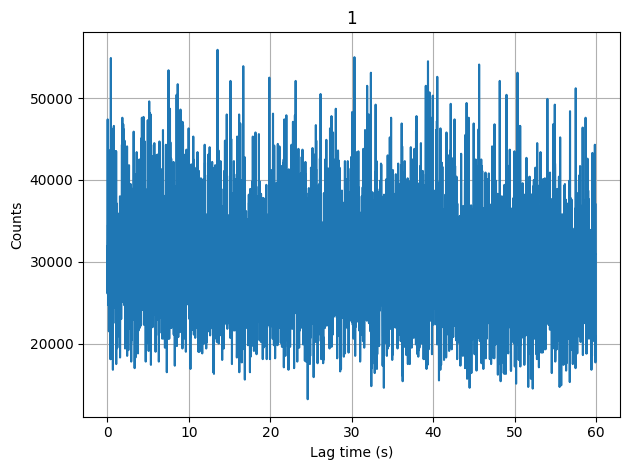

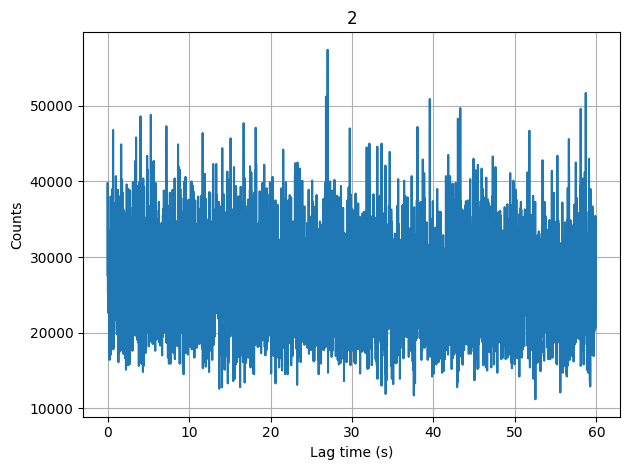

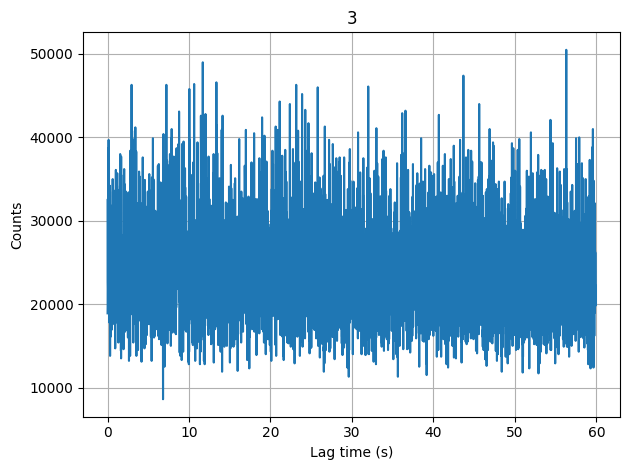

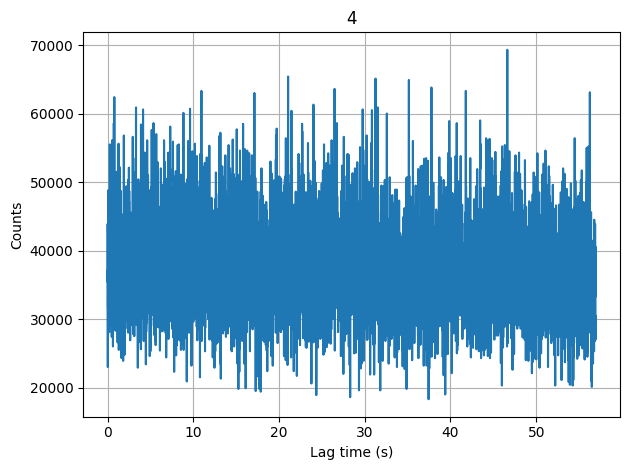

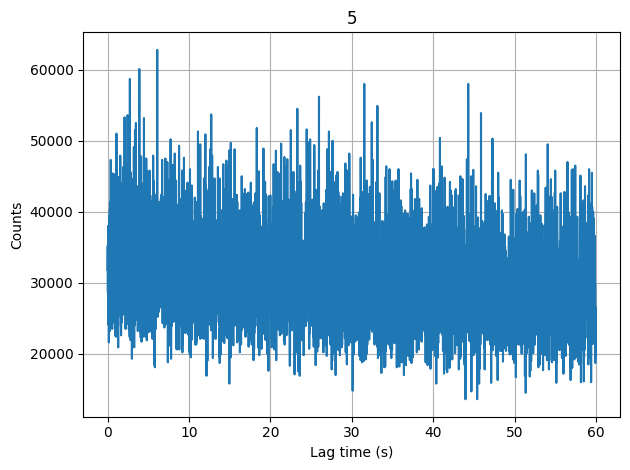

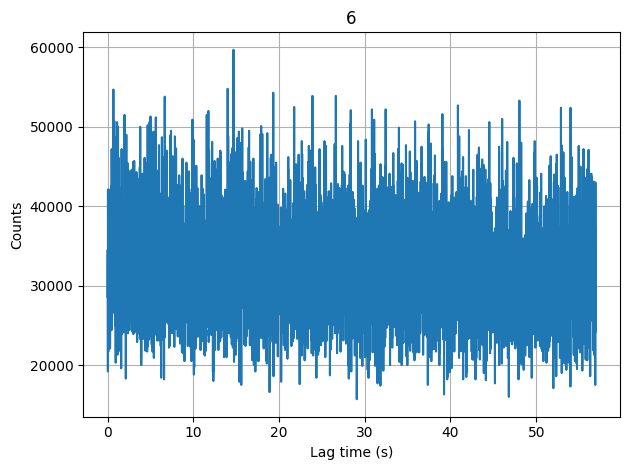

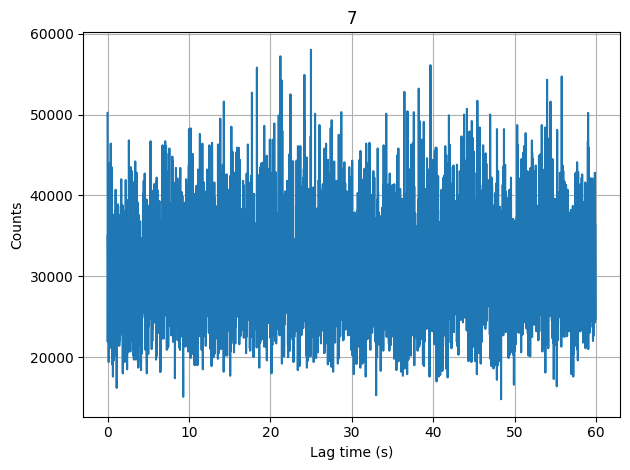

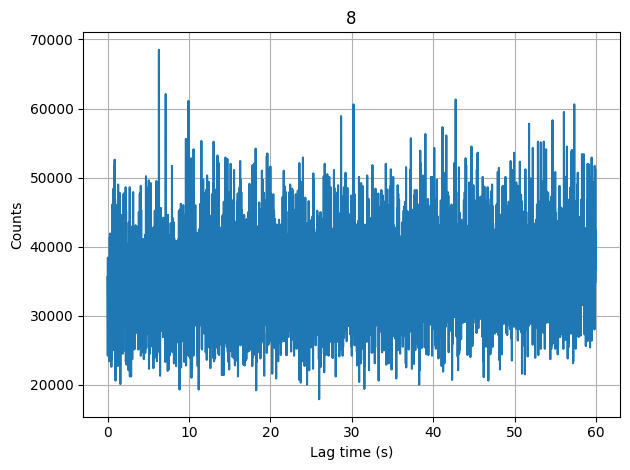

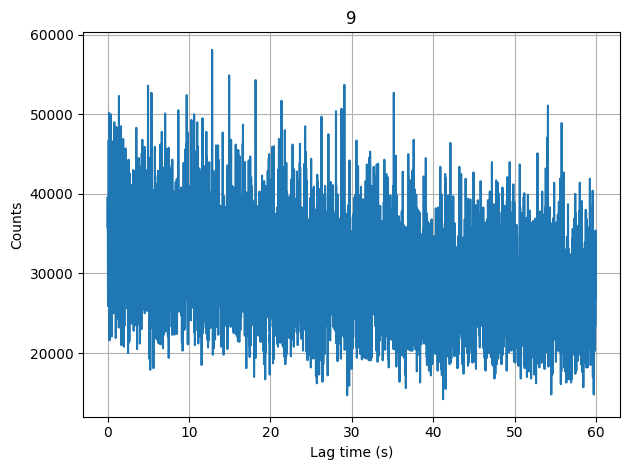

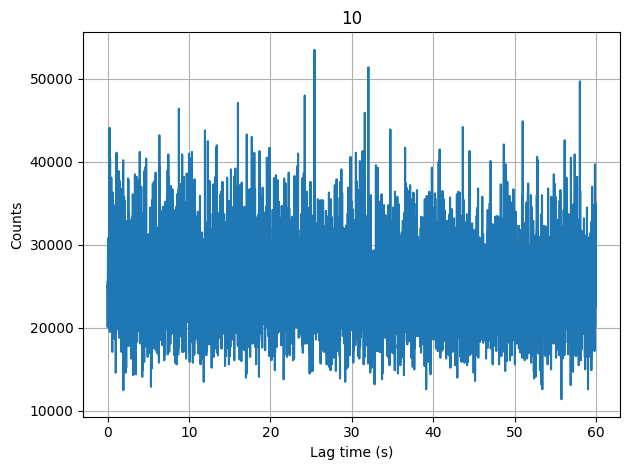

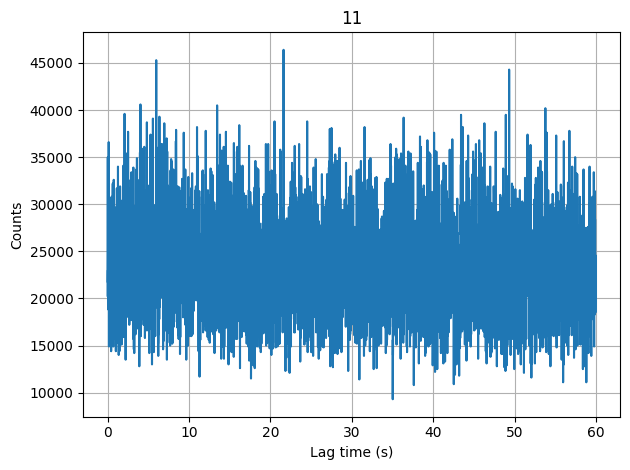

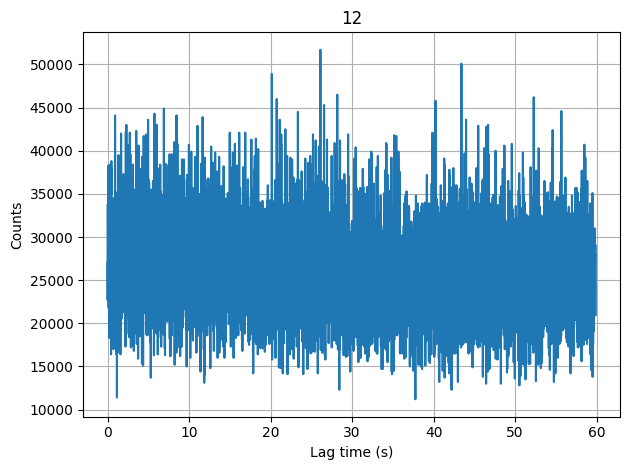

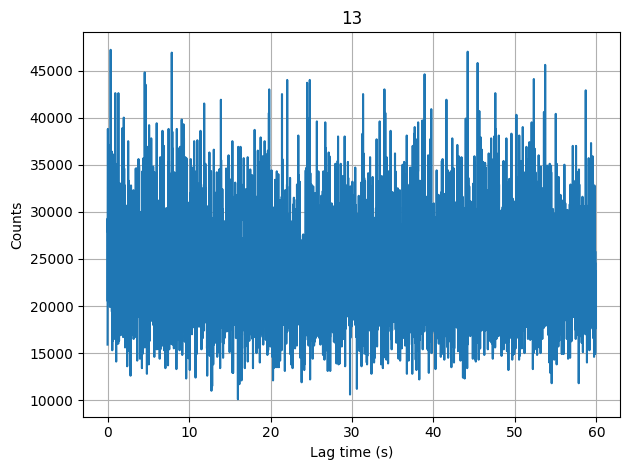

In [4]:
#here I'll manually find the guys that grow in time

def stack_with_monotonic_time(blocks):
    combined = []
    time_offset = 0.0

    for i, block in enumerate(blocks):
        block = block.copy()
        if i > 0:
            # Get last time value of previous block
            prev_end_time = combined[-1][-1, 0]
            # Calculate current offset (ensure monotonicity)
            time_offset = prev_end_time + (block[1, 0] - block[0, 0])
        block[:, 0] += time_offset
        combined.append(block)

    return np.vstack(combined)

peak = 70000
noiseList = []
count=0
for filename in os.listdir(directory):
    if filename.lower().endswith(".txt"):
        noise, corr = extract_blocks(filename)

        # Filter out blocks with peaks
        filtered_noise_blocks = [block for block in noise if np.all(block[:, 1] <= peak)]
        filtered_corr_blocks  = [block for block in corr  if np.all(block[:, 1] <= peak)]

        if not filtered_noise_blocks:
            print(f"All blocks in {filename} had peaks > {peak}, skipping.")
            continue
        
        count+=1
        
        all_noise_in_time = stack_with_monotonic_time(filtered_noise_blocks)
        all_corr_in_time  = stack_with_monotonic_time(filtered_corr_blocks)

        noiseList.append(all_noise_in_time)

        # Plot only what remains
        plt.plot(all_noise_in_time[:, 0], all_noise_in_time[:, 1])
        plt.xlabel("Lag time (s)")
        plt.ylabel("Counts")
        plt.title(count)
        plt.grid(True)
        plt.tight_layout()
        plt.show()



Let's now work on one specific guy and try to find monotonic noise 

In [14]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy as np
import math

chunk = 500
d = 0.155

# Set how many subplots per page (e.g. 3x4)
ncols = 3
nrows = 4
plots_per_page = ncols * nrows

# Create A4 figure size in inches: 8.27 × 11.69
figsize = (8.27, 11.69)

with PdfPages(f'noiseFiltered_d_{int (1000*d)}_chunk_500.pdf') as pdf:
    # Dodanie strony tytułowej
    fig_title, ax_title = plt.subplots(figsize=figsize)
    ax_title.axis('off')  # Ukryj osie
    text = f"Noise Filter Summary\n\nParameter d = {d}\nChunk size = {chunk}.\nd: d<Abs[x(t_final)-t_initial]/Std[segment from t_f to t_i]"
    ax_title.text(0.5, 0.5, text, ha='center', va='center', fontsize=16)
    pdf.savefig(fig_title)
    plt.close(fig_title)

    total_traces = len(noiseList)
    pages = math.ceil(total_traces / plots_per_page)

    for page in range(pages):
        fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
        axes = axes.flatten()  # Make it easier to index
        
        for i in range(plots_per_page):
            index = page * plots_per_page + i
            if index >= total_traces:
                axes[i].axis('off')  # Hide unused subplot
                continue

            oneNoise = noiseList[index]

            meansOneNoise = [np.mean(oneNoise[j:j+chunk], axis=0) for j in range(0, len(oneNoise), chunk)]
            stdOneNoise   = [np.std(oneNoise[j:j+chunk], axis=0) for j in range(0, len(oneNoise), chunk)]
            meansOneNoise = np.array(meansOneNoise)
            stdOneNoise   = np.array(stdOneNoise)

            meansDiffOneNoise = [
                np.abs(meansOneNoise[j+1][1] - meansOneNoise[j][1]) / stdOneNoise[j+1][1]
                for j in range(len(meansOneNoise) - 1)
            ]
            meansDiffOneNoise = np.array(meansDiffOneNoise)

            mask = meansDiffOneNoise < d

            max_len = 0
            current_len = 0
            best_start = 0

            for j, val in enumerate(mask):
                if val:
                    current_len += 1
                    if current_len > max_len:
                        max_len = current_len
                        best_start = j - max_len + 1
                else:
                    current_len = 0

            start = best_start * chunk
            end = (best_start + max_len) * chunk

            ax = axes[i]
            ax.plot(oneNoise[:start, 0], oneNoise[:start, 1], color="red", label="bad d>0.14")
            ax.plot(oneNoise[start:end, 0], oneNoise[start:end, 1], color="green", label="good d<0.14")
            ax.plot(oneNoise[end:, 0], oneNoise[end:, 1], color="red")
            ax.set_title(f"#{index+1}", fontsize=8)
            ax.set_xlim(0, 60)
            ax.tick_params(labelsize=6)

        fig.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)


USELESS

In [ ]:
count = 0
d = 0.15
chunk = 500

with PdfPages('noiseFiltered_d_015_chunk_500.pdf') as pdf:
    for oneNoise in noiseList:
        count += 1

        meansOneNoise = [np.mean(oneNoise[i:i + chunk], axis=0) for i in range(0, len(oneNoise), chunk)]
        stdOneNoise = [np.std(oneNoise[i:i + chunk], axis=0) for i in range(0, len(oneNoise), chunk)]
        meansOneNoise = np.array(meansOneNoise)
        stdOneNoise = np.array(stdOneNoise)

        meansDiffOneNoise = [
            np.abs(meansOneNoise[i + 1][1] - meansOneNoise[i][1]) / stdOneNoise[i + 1][1]
            for i in range(len(meansOneNoise) - 1)
        ]
        meansDiffOneNoise = np.array(meansDiffOneNoise)

        mask = meansDiffOneNoise < d

        max_len = 0
        current_len = 0
        start_idx = 0
        best_start = 0

        for i, val in enumerate(mask):
            if val:
                if current_len == 0:
                    start_idx = i
                current_len += 1
                if current_len > max_len:
                    max_len = current_len
                    best_start = start_idx
            else:
                current_len = 0

        start = best_start * chunk
        end = (best_start + max_len) * chunk

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(oneNoise[:start, 0], oneNoise[:start, 1], color="red", label="not valid")
        ax.plot(oneNoise[start:end, 0], oneNoise[start:end, 1], color="green", label="valid")
        ax.plot(oneNoise[end:, 0], oneNoise[end:, 1], color="red")

        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_title(count)
        ax.legend()
        ax.set_xlim(0, 60)
        fig.tight_layout()

        pdf.savefig(fig)  # Save this figure
        plt.close(fig)    # Clean up memory


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy as np
import math

chunk = 500
d = 0.14

# Set how many subplots per page (e.g. 3x4)
ncols = 3
nrows = 4
plots_per_page = ncols * nrows

# Create A4 figure size in inches: 8.27 × 11.69
figsize = (8.27, 11.69)

with PdfPages('noiseFiltered_d_02_chunk_500.pdf') as pdf:
    total_traces = len(noiseList)
    pages = math.ceil(total_traces / plots_per_page)

    for page in range(pages):
        fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
        axes = axes.flatten()  # Make it easier to index
        
        for i in range(plots_per_page):
            index = page * plots_per_page + i
            if index >= total_traces:
                axes[i].axis('off')  # Hide unused subplot
                continue

            oneNoise = noiseList[index]

            meansOneNoise = [np.mean(oneNoise[j:j+chunk], axis=0) for j in range(0, len(oneNoise), chunk)]
            stdOneNoise   = [np.std(oneNoise[j:j+chunk], axis=0) for j in range(0, len(oneNoise), chunk)]
            meansOneNoise = np.array(meansOneNoise)
            stdOneNoise   = np.array(stdOneNoise)

            meansDiffOneNoise = [
                np.abs(meansOneNoise[j+1][1] - meansOneNoise[j][1]) / stdOneNoise[j+1][1]
                for j in range(len(meansOneNoise) - 1)
            ]
            meansDiffOneNoise = np.array(meansDiffOneNoise)

            mask = meansDiffOneNoise < d

            max_len = 0
            current_len = 0
            best_start = 0

            for j, val in enumerate(mask):
                if val:
                    current_len += 1
                    if current_len > max_len:
                        max_len = current_len
                        best_start = j - max_len + 1
                else:
                    current_len = 0

            start = best_start * chunk
            end = (best_start + max_len) * chunk

            ax = axes[i]
            ax.plot(oneNoise[:start, 0], oneNoise[:start, 1], color="red", label="bad d>0.2")
            ax.plot(oneNoise[start:end, 0], oneNoise[start:end, 1], color="green", label="good d<0.2")
            ax.plot(oneNoise[end:, 0], oneNoise[end:, 1], color="red")
            ax.set_title(f"#{index+1}", fontsize=8)
            ax.set_xlim(0, 60)
            ax.tick_params(labelsize=6)

        fig.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)


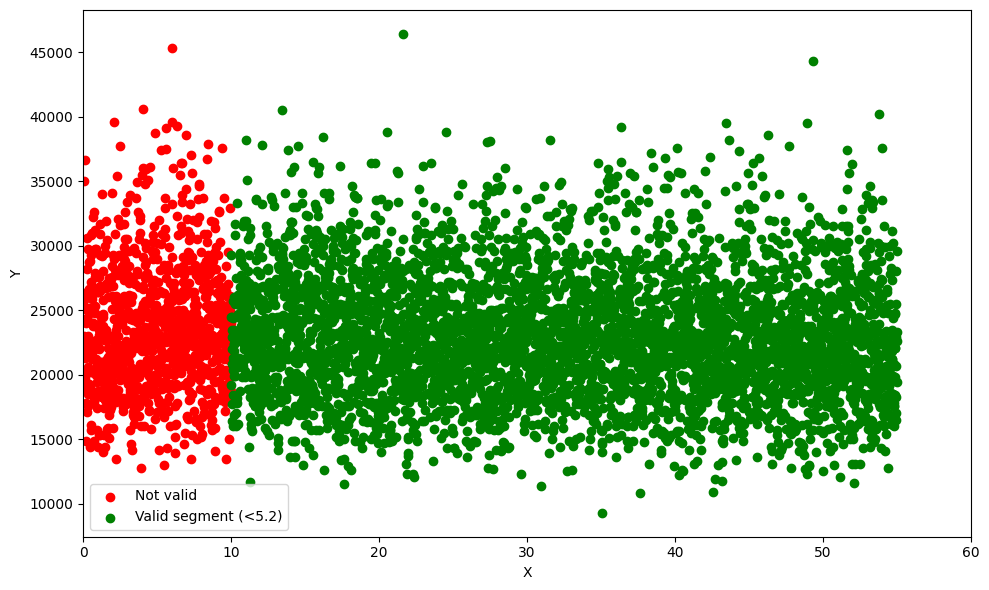

In [96]:
oneNoise=noiseList[10]
chunk = 500
meansOneNoise = [np.mean(oneNoise[i:i+chunk], axis=0) for i in range(0, len(oneNoise), chunk)]
stdOneNoise = [np.std(oneNoise[i:i+chunk], axis=0) for i in range(0, len(oneNoise), chunk)]
meansOneNoise = np.array(meansOneNoise)
stdOneNoise = np.array(stdOneNoise)

meansDiffOneNoise=[]
for i in np.arange(0,len(meansOneNoise)-1):
    meansDiffOneNoise.append(np.abs(meansOneNoise[i+1][1]-meansOneNoise[i][1])/stdOneNoise[i+1][1])
meansDiffOneNoise=np.array(meansDiffOneNoise)

mask = meansDiffOneNoise < 0.1

max_len = 0
current_len = 0
start_idx = 0
best_start = 0

for i, val in enumerate(mask):
    if val:
        if current_len == 0:
            start_idx = i
        current_len += 1
        if current_len > max_len:
            max_len = current_len
            best_start = start_idx
    else:
        current_len = 0

start = best_start * chunk
end = (best_start + max_len) * chunk

plt.figure(figsize=(10, 6))

# Before segment
plt.scatter(oneNoise[:start, 0], oneNoise[:start, 1], color="red", label="Not valid")

# Segment itself
plt.scatter(oneNoise[start:end, 0], oneNoise[start:end, 1], color="green", label="Valid segment (<5.2)")


plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.xlim(0, 60)
plt.tight_layout()
plt.show()

In [95]:
meansDiffOneNoise

array([ 0.11998351, -0.10765054,  0.00546766, -0.05298442, -0.06568042,
        0.04333711, -0.00915878, -0.06739137, -0.0340962 , -0.00220116,
       -0.04648861])

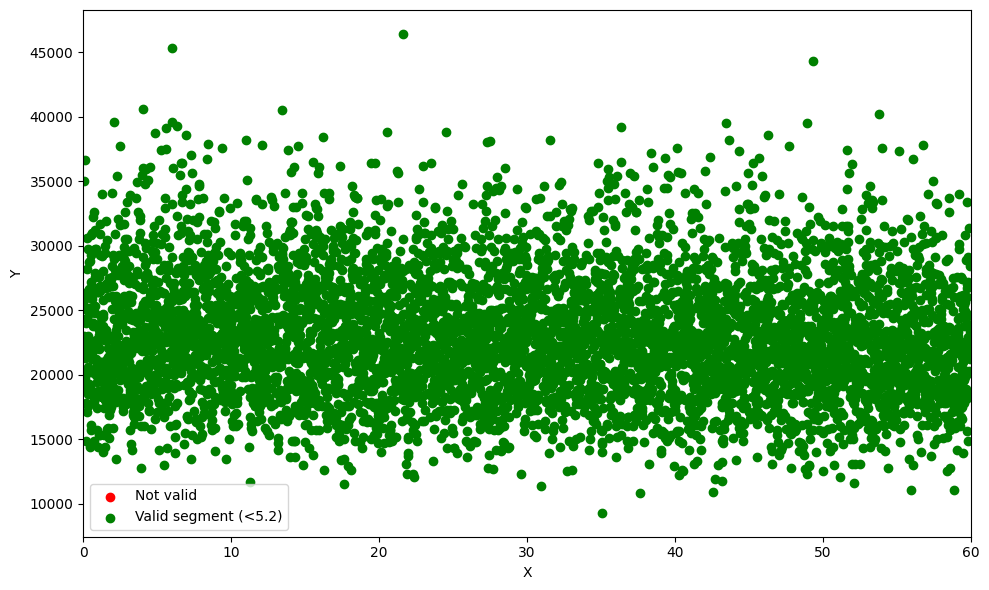

In [92]:
mask = (meansOneNoise[:,1] / stdOneNoise[:,1]) < 5.2

# Find the longest sequence of True values
max_len = 0
current_len = 0
start_idx = 0
best_start = 0

for i, val in enumerate(mask):
    if val:
        if current_len == 0:
            start_idx = i
        current_len += 1
        if current_len > max_len:
            max_len = current_len
            best_start = start_idx
    else:
        current_len = 0

# Extract the slice
longest_segment = meansOneNoise[best_start:best_start + max_len]
std_segment     = stdOneNoise[best_start:best_start + max_len]

start = best_start * chunk
end = (best_start + max_len) * chunk

plt.figure(figsize=(10, 6))

# Before segment
plt.scatter(oneNoise[:start, 0], oneNoise[:start, 1], color="red", label="Not valid")

# Segment itself
plt.scatter(oneNoise[start:end, 0], oneNoise[start:end, 1], color="green", label="Valid segment (<5.2)")


plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.xlim(0, 60)
plt.tight_layout()
plt.show()

END

In [28]:
for i in np.arange(0,len(meansOneNoise)-1):
    print(meansOneNoise[:,1][i+1]-meansOneNoise[:,1][i])

-1100.4000000000015
-263.7999999999993
-570.4000000000015
-208.0
-645.2000000000007
-303.59999999999854
-760.7999999999993
175.39999999999782
-692.3999999999978
-78.0
-162.45354969573964


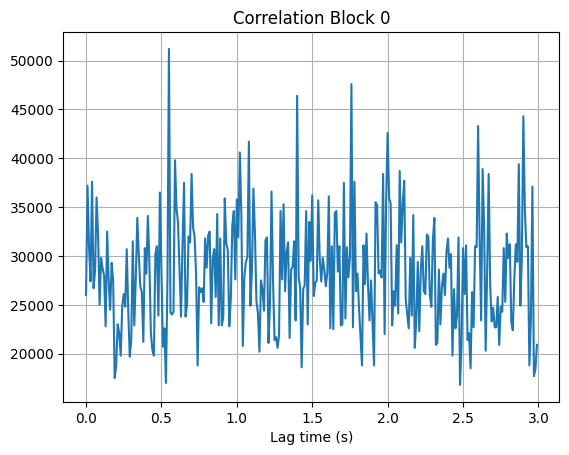

In [ ]:
# Load the blocks
noise, corr = extract_blocks("200 nM Lys buf kr 1 nr 1.txt")

plt.plot(noise[19][:, 0], noise[19][:, 1])
plt.xlabel("Lag time (s)")
plt.title("Correlation Block 0")
plt.grid(True)
plt.show()

In [5]:
print(f"len(dzwieku samotnosci): {len(noise)},{len(corr)}")

len(dzwieku samotnosci): 20,20


Now we want to see if the measurement is ok i.e. no peaks and no up/down trend in noise

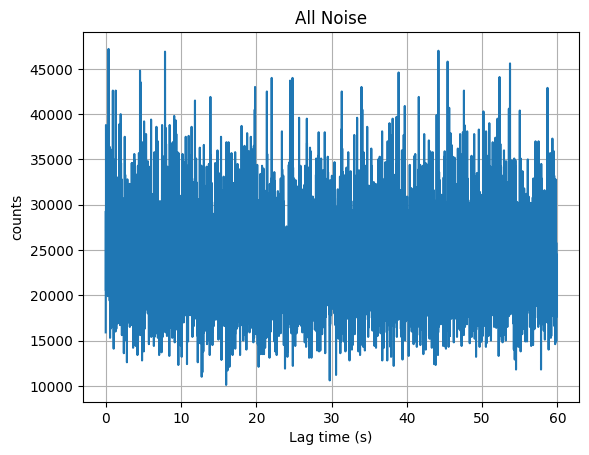

In [5]:
#function to combine all noise 

def stack_with_monotonic_time(blocks):
    combined = []
    time_offset = 0.0

    for i, block in enumerate(blocks):
        block = block.copy()
        if i > 0:
            # Get last time value of previous block
            prev_end_time = combined[-1][-1, 0]
            # Calculate current offset (ensure monotonicity)
            time_offset = prev_end_time + (block[1, 0] - block[0, 0])
        block[:, 0] += time_offset
        combined.append(block)

    return np.vstack(combined)

all_noise_in_time = stack_with_monotonic_time(noise)

plt.plot(all_noise_in_time[:,0], all_noise_in_time[:,1])
plt.xlabel("Lag time (s)")
plt.ylabel("counts")
plt.title("All Noise")
plt.grid(True)
plt.show()

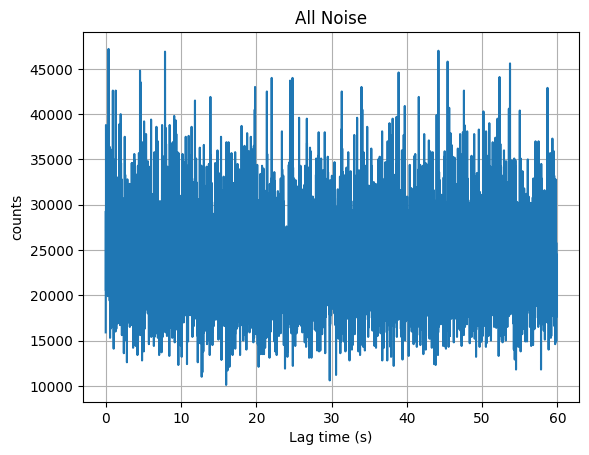

In [40]:
#Deleting peaks, value peak should be given by the user

peak=70000
noiseNoPeaks = []
corrNoPeaks = []
for noiseBlock, corrBlock in zip(noise, corr):
    if np.all(noiseBlock[:, 1] <= peak):
        noiseNoPeaks.append(noiseBlock)
        corrNoPeaks.append(corrBlock)



allNoiseInTimeNoPeaks = stack_with_monotonic_time(noiseNoPeaks)


plt.plot(allNoiseInTimeNoPeaks[:,0], allNoiseInTimeNoPeaks[:,1])
plt.xlabel("Lag time (s)")
plt.ylabel("counts")
plt.title("All Noise")
plt.grid(True)
plt.show()

In [7]:
meansFirstDim=[]
for n in noiseNoPeaks:
    meansFirstDim.append(np.mean(n[:,1]))
meansFirstDim = np.array(meansFirstDim)

trimmedMean = np.mean(sorted(meansFirstDim)[2:-2]) 

print(np.mean(means),trimmedMean)

NameError: name 'means' is not defined

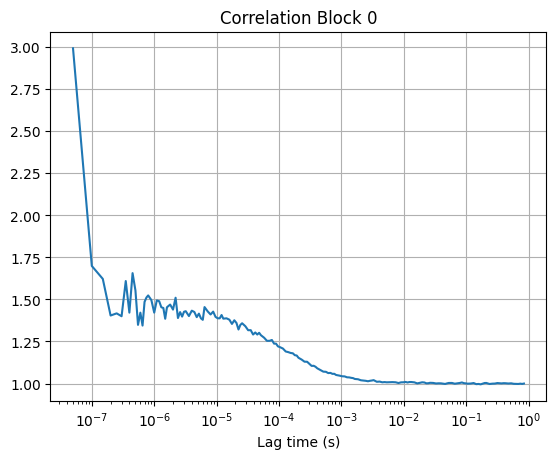

In [11]:
plt.plot(corr[19][:, 0], corr[19][:, 1])
plt.xlabel("Lag time (s)")
plt.xscale("log")
plt.title("Correlation Block 0")
plt.grid(True)
plt.show()

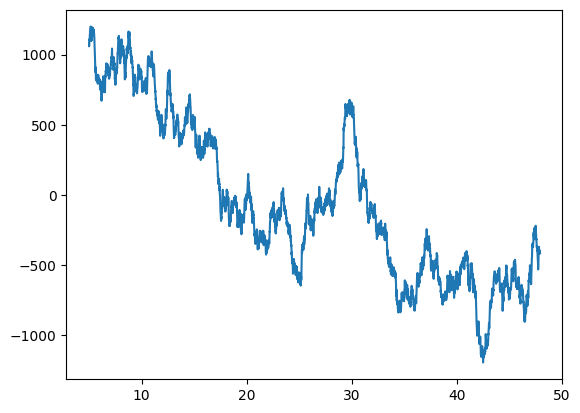

In [ ]:
def movingAverage(data, window):
   
   firstDimMA = np.convolve(data[:,1], np.ones(window)/window, mode="valid")
   times = data[:,0]
   meanFirstDim=np.mean(data[:,1])
   timesAndFirstDimMA=[]
   
   for i,j in zip(range(len(data[:,1])-len(firstDimMA),len(data[:,1])), range(1,len(firstDimMA))):
      timesAndFirstDimMA.append([times[i],firstDimMA[j]-meanFirstDim])
   
   timesAndFirstDimMA=np.array(timesAndFirstDimMA)
   return timesAndFirstDimMA

allNoiseMA=movingAverage(allNoiseInTimeNoPeaks,500)
plt.plot(allNoiseMA[:,0], (allNoiseMA[:,1]))

plt.show()

tu se czat coś sfitował

C:\Users\igork\AppData\Local\Temp\ipykernel_13720\3581258402.py:5: RuntimeWarning: invalid value encountered in power
  g1 = (1 / N1) * (1 + tau / tauD1)**-1 * (1 + tau / (tauD1 * kappa**2))**-0.5


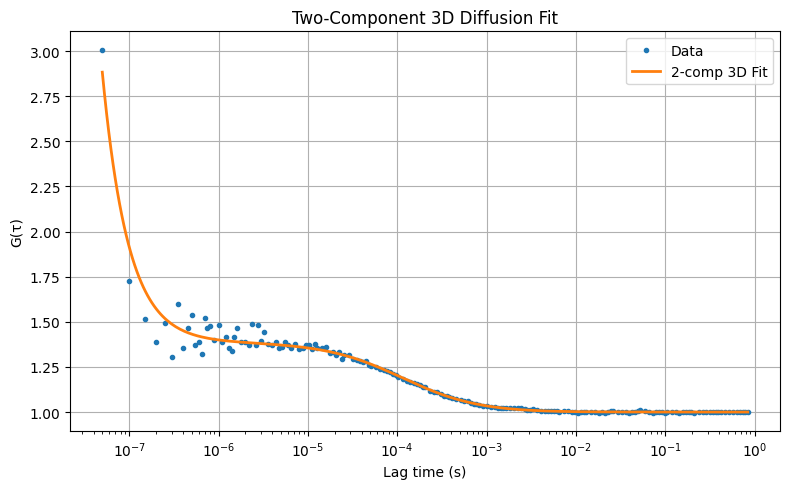

In [104]:
kappa=5

# --- Model: 2-component 3D diffusion ---
def two_component_3d_diffusion(tau, N1, tauD1, N2, tauD2, offset):
    g1 = (1 / N1) * (1 + tau / tauD1)**-1 * (1 + tau / (tauD1 * kappa**2))**-0.5
    g2 = (1 / N2) * (1 + tau / tauD2)**-1 * (1 + tau / (tauD2 * kappa**2))**-0.5
    return g1 + g2 + offset

# --- Load data from corr[0] ---
x = corr[0][:, 0]  # lag time (s)
y = corr[0][:, 1]  # G(t)

# --- Initial guesses: [N1, τD1, N2, τD2, κ, offset] ---
p0 = [2.0, np.median(x)/10, 1.0, np.median(x), min(y)]

# --- Fit the model ---
params, _ = curve_fit(two_component_3d_diffusion, x, y, p0=p0, maxfev=5000)

# --- Generate fitted curve ---
x_fit = np.logspace(np.log10(min(x)), np.log10(max(x)), 300)
y_fit = two_component_3d_diffusion(x_fit, *params)

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'o', markersize=3, label='Data')
plt.plot(x_fit, y_fit, '-', linewidth=2, label='2-comp 3D Fit')
plt.xlabel("Lag time (s)")
plt.xscale("log")
plt.ylabel("G(τ)")
plt.title("Two-Component 3D Diffusion Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [105]:
param_labels = ["N1", "tauD1", "N2", "tauD2", "offset"]

# Create and print dictionary of results
fit_results = dict(zip(param_labels, params))
for name, value in fit_results.items():
    print(f"{name:8} = {value:.6g}")

N1       = 5.61836e-11
tauD1    = 3.28198e-15
N2       = 2.59014
tauD2    = 0.000114557
offset   = 1.00041
